In [1]:
import harp
import pandas as pd

reader = harp.create_reader('device.yml', epoch=harp.REFERENCE_EPOCH)
# reader = harp.create_reader('src/data/2023-12-12T17-41-06/Expander/'

In [3]:
datafolder = r'../src/data/2023-12-12T17-41-06/Expander/'

# times when inputs changed state
pokes = reader.AuxInState.read('../src/data/2023-12-12T17-41-06/Expander/Expander_32_2023-12-12T17-00-00.bin')

# times when outputs were set to HIGH (e.g. port valve opening, manifold valve opening)
outputs_HIGH = reader.OutputSet.read('../src/data/2023-12-12T17-41-06/Expander/Expander_35_2023-12-12T17-00-00.bin')

# times when outputs were set to LOW (e.g. port valve closing, manifold closing)
outputs_LOW = reader.OutputClear.read('../src/data/2023-12-12T17-41-06/Expander/Expander_36_2023-12-12T17-00-00.bin')

<Axes: xlabel='Time'>

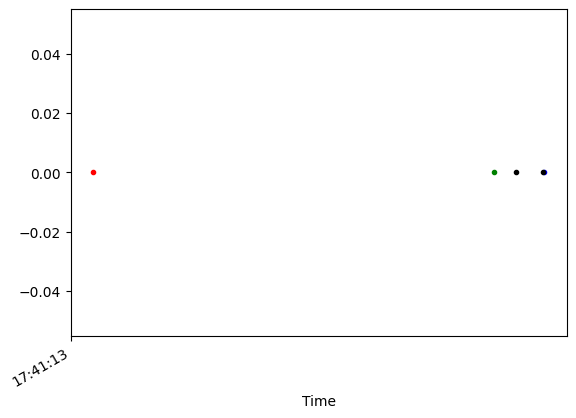

In [4]:
portvalve_open = pokes.Aux0[pokes.Aux0] * 0
portvalve_close = pokes.Aux0[~pokes.Aux0] * 0
odor0_open = outputs_HIGH.Out6[outputs_HIGH.Out6] * 0
odor1_open = outputs_HIGH.Out7[outputs_HIGH.Out7] * 0
odor2_open = outputs_HIGH.Out8[outputs_HIGH.Out8] * 0
odor3_open = outputs_HIGH.Out9[outputs_HIGH.Out9] * 0
odors_close = outputs_LOW.Out6[outputs_LOW.Out6] * 0

start_time = pd.to_datetime('2023-12-12T17:41:06')
end_time = start_time + pd.Timedelta('10sec')

portvalve_open[start_time:end_time].plot(style='r.')
portvalve_close[start_time:end_time].plot(style='g.')
odor1_open[start_time:end_time].plot(style='b.')
odors_close[start_time:end_time].plot(style='k.')
# pokes.Aux0.astype('uint8').plot(style='.')
# portvalve_open[start_time:end_time]